### **Áreas para Generar Nuevas Features**

#### **1. A partir del dataset de usuarios (`user_data`)**
- **Segmentación geográfica:** 
  - Crear categorías a partir de `country`, por ejemplo, regiones o clústeres de países.
- **RFM combinada:**
  - Generar una métrica compuesta basada en `R`, `F`, y `M` (como una puntuación RFM).
- **Categorías de comportamiento:**
  - Clasificar a los usuarios según su frecuencia (`F`) o valor monetario (`M`) en segmentos (e.g., "frecuentes", "premium").

#### **2. A partir del dataset de productos (`products_data`)**
- **Vector de similitud:**
  - Calcular similitudes entre productos usando los `embedding`.
- **Descuentos:**
  - Generar una columna binaria o categórica indicando productos siempre con descuento o sin descuento.
- **Popularidad:**
  - Agregar una métrica de ventas basada en `train_data` (frecuencia de aparición de `partnumber`).

#### **3. A partir del dataset de sesiones (`train_data` y `test_data`)**
- **Interacción reciente:**
  - Tiempo transcurrido desde la última interacción (`timestamp_local`).
- **Patrones por dispositivo:**
  - Identificar tendencias según `device_type` (e.g., preferencia de dispositivos móviles).
- **Comportamiento por sesión:**
  - Contar cuántas interacciones distintas tuvo una sesión (agrupando por `session_id`).
- **Frecuencia de productos:**
  - Generar una métrica de "popularidad por sesión" para los productos más vistos o añadidos al carrito.

#### **4. Combinación de Datasets**
- **Perfil del usuario + Producto:**
  - Crear features que combinen características del usuario y del producto (e.g., ¿este usuario compra productos de esta categoría?).
- **Contexto geográfico:**
  - Analizar si ciertos productos son más populares en ciertos países (`country`).


---

# User

### **Objetivos en el Feature Engineering para Usuarios**
1. **Segmentación RFM:**
   - Agrupar usuarios según sus métricas de recencia (`R`), frecuencia (`F`) y valor monetario (`M`).
   - Crear una métrica compuesta de RFM para identificar perfiles de usuarios.

2. **Segmentación geográfica:**
   - Analizar la distribución de usuarios por `country`.
   - Crear clústeres o categorías geográficas si aplica.

3. **Clasificación de usuarios:**
   - Identificar usuarios "premium" basados en alto gasto (`M`) y alta frecuencia (`F`).
   - Crear categorías de usuarios según comportamiento (e.g., "ocasional", "frecuente", "alto valor").


             user_id        country              R              F  \
count  557006.000000  557006.000000  557006.000000  557006.000000   
mean   278503.500000      25.129246       0.057873       0.003435   
std    160793.926358       2.781777       0.117508       0.005338   
min         1.000000       1.000000       0.000000       0.000000   
25%    139252.250000      25.000000       0.004566       0.000744   
50%    278503.500000      25.000000       0.016438       0.002046   
75%    417754.750000      25.000000       0.052968       0.004370   
max    557006.000000      93.000000       1.000000       1.000000   

                   M  
count  557006.000000  
mean        0.000026  
std         0.002493  
min         0.000000  
25%         0.000002  
50%         0.000003  
75%         0.000003  
max         1.000000  


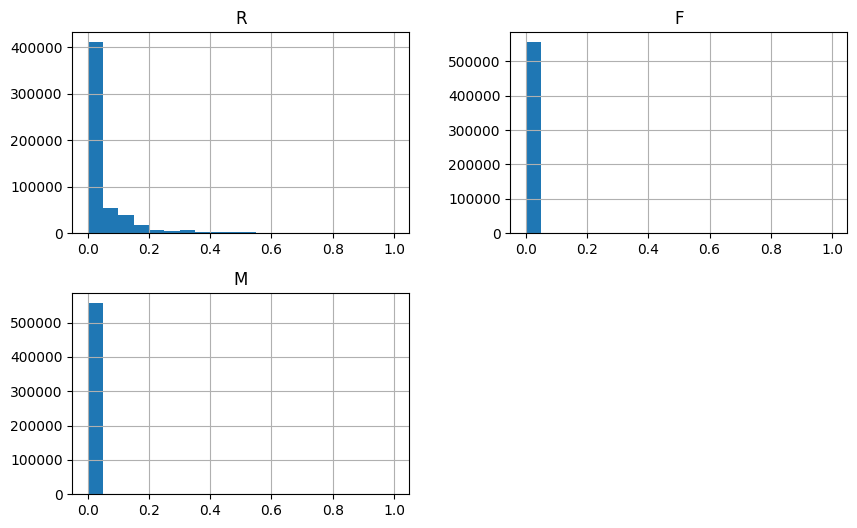

In [1]:
import pandas as pd

# Cargar user_data
user_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/user_data.csv'
user_data = pd.read_csv(user_data_path)

# Estadísticas descriptivas
print(user_data.describe())

# Distribución de las métricas R, F, M
import matplotlib.pyplot as plt

user_data[['R', 'F', 'M']].hist(bins=20, figsize=(10, 6))
plt.show()


### **Observaciones Clave del Análisis**
1. **R (Recencia):**
   - Distribución sesgada hacia valores bajos.
   - La mayoría de los usuarios interactuaron recientemente (valores cercanos a `0`).

2. **F (Frecuencia):**
   - Valores extremadamente bajos para la mayoría de los usuarios.
   - Solo un pequeño porcentaje tiene una frecuencia significativa.

3. **M (Monetario):**
   - Similar a `F`, con valores bajos para la mayoría.
   - Sesgo fuerte hacia usuarios con gastos pequeños.

4. **Country:**
   - La mayoría de los usuarios pertenecen al país `25`, con una desviación estándar pequeña. Puede ser útil agrupar países en regiones para mayor diversidad.


### **Plan para Nuevas Características**

#### **1. Segmentación RFM**
Vamos a agrupar los usuarios según las métricas de recencia (`R`), frecuencia (`F`), y valor monetario (`M`):

- **Clasificación en cuartiles:**
  - `R`: Menor es mejor (valores bajos son más recientes).
  - `F` y `M`: Mayor es mejor (valores altos indican mayor actividad/gasto).



In [2]:
# Clasificar R, F, M en cuartiles
user_data['R_segment'] = pd.qcut(user_data['R'], 4, labels=[4, 3, 2, 1])  # Menor R es mejor
user_data['F_segment'] = pd.qcut(user_data['F'], 4, labels=[1, 2, 3, 4])  # Mayor F es mejor
user_data['M_segment'] = pd.qcut(user_data['M'], 4, labels=[1, 2, 3, 4])  # Mayor M es mejor

# Crear métrica RFM compuesta
user_data['RFM_score'] = user_data['R_segment'].astype(int) + user_data['F_segment'].astype(int) + user_data['M_segment'].astype(int)

# Mostrar la distribución de la RFM_score
print(user_data['RFM_score'].value_counts())


RFM_score
9     86467
8     84103
7     78588
6     77367
10    63606
5     50428
11    38981
4     34904
3     26832
12    15730
Name: count, dtype: int64


#### **2. Clasificación de Usuarios**
Basándonos en el `RFM_score`, categorizaremos a los usuarios en:
- **Ocasionales:** Baja actividad general.
- **Frecuentes:** Actividad moderada.
- **Premium:** Alta frecuencia y gasto.


In [3]:
# Clasificación según RFM_score
def classify_user(rfm_score):
    if rfm_score <= 6:
        return 'Ocasional'
    elif 6 < rfm_score <= 9:
        return 'Frecuente'
    else:
        return 'Premium'

user_data['user_class'] = user_data['RFM_score'].apply(classify_user)

# Verificar la distribución de las clases
print(user_data['user_class'].value_counts())

user_class
Frecuente    249158
Ocasional    189531
Premium      118317
Name: count, dtype: int64


#### **3. Análisis Geográfico**
Si la mayoría de los usuarios provienen de un solo país (`25`), podemos agrupar países en categorías regionales para agregar diversidad.



In [4]:
# Crear regiones basadas en country
def map_region(country_id):
    if country_id in [1, 2, 3]:  # Ejemplo de países europeos
        return 'Europe'
    elif country_id in [25, 26]:  # Ejemplo de países de América
        return 'America'
    else:
        return 'Other'

user_data['region'] = user_data['country'].apply(map_region)

# Verificar la distribución por región
print(user_data['region'].value_counts())


region
America    547050
Other        9920
Europe         36
Name: count, dtype: int64


### **Resultados**
1. **`RFM_score`:**
   - El puntaje varía entre 3 y 12, lo cual es consistente con los segmentos creados.
   - Los valores medios (6-9) son los más comunes, mientras que los extremos (3 y 12) tienen menos usuarios, lo que refleja diversidad en los perfiles.

2. **`user_class`:**
   - **Frecuentes:** 249,158 usuarios (44.7%) – Segmento más común.
   - **Ocasionales:** 189,531 usuarios (34.0%) – Usuarios con actividad baja.
   - **Premium:** 118,317 usuarios (21.2%) – Usuarios de alto valor.

   Este desglose es útil para priorizar recomendaciones en el sistema.

3. **`region`:**
   - La mayoría de los usuarios pertenecen a **América** (547,050 usuarios, 98.2%).
   - Las regiones **"Other"** y **"Europe"** tienen pocos usuarios, lo que podría influir en el peso de las recomendaciones basadas en región.


---

### Guardar el Dataset Enriquecido:

In [5]:
user_data.to_csv('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/user_data_enriched.csv', index=False)


### **Resultados**
1. **`RFM_score`:**
   - El puntaje varía entre 3 y 12, lo cual es consistente con los segmentos creados.
   - Los valores medios (6-9) son los más comunes, mientras que los extremos (3 y 12) tienen menos usuarios, lo que refleja diversidad en los perfiles.

2. **`user_class`:**
   - **Frecuentes:** 249,158 usuarios (44.7%) – Segmento más común.
   - **Ocasionales:** 189,531 usuarios (34.0%) – Usuarios con actividad baja.
   - **Premium:** 118,317 usuarios (21.2%) – Usuarios de alto valor.

   Este desglose es útil para priorizar recomendaciones en el sistema.

3. **`region`:**
   - La mayoría de los usuarios pertenecen a **América** (547,050 usuarios, 98.2%).
   - Las regiones **"Other"** y **"Europe"** tienen pocos usuarios, lo que podría influir en el peso de las recomendaciones basadas en región.


---

# Products

1. **Exploración inicial:**
   - Revisar la distribución de las columnas principales (`discount`, `embedding`, `partnumber`, `color_id`, `cod_section`, `family`).

2. **Feature Engineering:**
   - Crear nuevas características como:
     - Popularidad del producto (a partir de `train_data`).
     - Similitudes entre productos basadas en `embedding`.
     - Análisis de descuentos.

3. **Optimización:**
   - Asegurar que los datos estén listos para alimentar el modelo.


1. **Exploración inicial:**

In [4]:
import pandas as pd

# Cargar products_data
products_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/products_data.pkl'
products_data = pd.read_pickle(products_data_path)

# Exploración inicial
print(products_data.info())
print(products_data.head())
print(products_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   discount     43692 non-null  int8  
 1   embedding    43692 non-null  object
 2   partnumber   43692 non-null  int32 
 3   color_id     43692 non-null  int32 
 4   cod_section  43692 non-null  int16 
 5   family       43692 non-null  int32 
dtypes: int16(1), int32(3), int8(1), object(1)
memory usage: 981.5+ KB
None
   discount                                          embedding  partnumber  \
0         0  [-0.13401361, -0.1200429, -0.016117405, -0.167...       32776   
1         0  [-0.0949274, -0.107294075, -0.16559914, -0.174...       41431   
2         0  [-0.12904441, -0.07724628, -0.09799071, -0.164...       39419   
3         1  [-0.12783332, -0.133868, -0.10101265, -0.18888...       36087   
4         1  [-0.14092924, -0.1258284, -0.10809927, -0.1765...       34132   

   color_id  cod_se

### **Análisis del Dataset de Productos**
1. **Estructura:**
   - **Número de registros:** 43,692.
   - **Columnas principales:**
     - `discount`: Binaria (`0` o `1`), indicando si el producto tiene descuento.
     - `embedding`: Vectores densos de características (listas), útiles para calcular similitudes entre productos.
     - `partnumber`, `color_id`, `cod_section`, `family`: Datos categóricos o identificadores.

2. **Distribuciones Clave:**
   - **`discount`:**
     - Muy pocos productos tienen descuento (`mean = 0.031` → ~3.1%).
   - **`partnumber`:**
     - Valores negativos en `partnumber`, posiblemente indicativos de productos especiales.
   - **`color_id`, `cod_section`, `family`:**
     - Estas columnas parecen bien distribuidas, sin valores faltantes.

3. **Tamaño:**
   - Uso de memoria optimizado (725.5 KB), gracias a los tipos de datos compactos (`int16`, `int8`).

#### **1. Popularidad del Producto**
Calcular la frecuencia con la que cada producto aparece en `train_data` para medir su popularidad:
- Más popular = más recomendado.


In [5]:
# Cargar train_data para calcular popularidad
train_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/train_data.pkl'
train_data = pd.read_pickle(train_data_path)

# Calcular popularidad
product_popularity = train_data['partnumber'].value_counts().reset_index()
product_popularity.columns = ['partnumber', 'popularity']

# Unir con products_data
products_data = products_data.merge(product_popularity, on='partnumber', how='left')

# Rellenar productos sin datos de popularidad con 0
products_data['popularity'] = products_data['popularity'].fillna(0).astype('int32')


#### **2. Similitud entre Productos**
Usando los embeddings, podemos calcular similitudes entre productos. Por ejemplo:
- Calcular una matriz de similitud entre productos (requiere cuidado por el tamaño).
- O simplemente seleccionar los productos más similares a cada producto.


---

### **Estrategias para Manejar Embeddings**

#### **2.1. Reducción de Dimensionalidad**
Utilizar técnicas como PCA (Análisis de Componentes Principales) para reducir el tamaño de los embeddings. Esto permite:
- Reducir el costo computacional al calcular similitudes.
- Mantener la mayor parte de la información relevante.


In [6]:
from sklearn.decomposition import PCA
import numpy as np

# Convertir embeddings a matriz para PCA
embedding_matrix = np.stack(products_data['embedding'])

# Reducir a 50 dimensiones
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Añadir los embeddings reducidos al dataset
products_data['reduced_embedding'] = list(reduced_embeddings)


#### **2.2. Clustering de Productos**
Clusterizar los productos en grupos similares usando los embeddings. Esto es útil para:
- Agrupar productos similares.
- Reducir la necesidad de calcular similitudes para todos los pares de productos.


In [7]:
from sklearn.cluster import KMeans

# Aplicar clustering (por ejemplo, 20 grupos)
kmeans = KMeans(n_clusters=20, random_state=42)
products_data['cluster'] = kmeans.fit_predict(reduced_embeddings)

# Ver distribución de productos por clúster
print(products_data['cluster'].value_counts())


cluster
1     7068
3     3187
5     3087
2     2880
12    2501
7     2084
13    2046
0     1963
4     1843
11    1841
9     1834
19    1788
17    1696
16    1670
8     1619
14    1486
18    1412
6     1338
10    1220
15    1129
Name: count, dtype: int64


#### **2.3. Precomputar Similitudes**
En lugar de calcular similitudes en tiempo real:
- Precomputar una matriz de similitudes entre productos más relevantes.
- Almacenar los "top N" productos más similares para cada producto.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Precomputar similitudes para los primeros 100 productos
similarity_matrix = cosine_similarity(reduced_embeddings[:100])

# Ejemplo: Obtener los productos más similares al primer producto
similar_products = np.argsort(similarity_matrix[0])[::-1][:10]
print(f"Productos más similares al producto 0: {similar_products}")


Productos más similares al producto 0: [ 0  2 31 19 68 35 78 17  4 18]


#### **2.4. Generar "Top N Productos Similares"**
Crear una columna que almacene los IDs de los productos más similares para cada producto.

In [9]:
# Función para obtener los productos más similares
def get_top_similarities(product_idx, similarity_matrix, top_n=5):
    # Ordenar índices por similitud en orden descendente
    similar_indices = np.argsort(similarity_matrix[product_idx])[::-1]
    # Excluir el producto actual y seleccionar los top_n similares
    return [int(idx) for idx in similar_indices if idx != product_idx][:top_n]

# Inicializar columna similar_products con valores vacíos
products_data['similar_products'] = None

# Asignar los productos más similares para los primeros 100 productos
for idx in range(len(similarity_matrix)):
    # Actualizar solo los primeros 100 productos
    products_data.loc[idx, 'similar_products'] = str(get_top_similarities(idx, similarity_matrix))

# Verificar los primeros valores
print(products_data[['partnumber', 'similar_products']].head(10))


   partnumber     similar_products
0       32776  [2, 31, 19, 68, 35]
1       41431  [11, 20, 8, 64, 69]
2       39419  [31, 0, 78, 17, 19]
3       36087   [8, 4, 20, 10, 25]
4       34132   [18, 3, 33, 10, 8]
5       40303   [67, 64, 1, 20, 8]
6       34133  [18, 7, 16, 24, 70]
7       33718  [24, 16, 70, 6, 18]
8       41664  [20, 11, 1, 69, 10]
9       42572   [11, 29, 1, 10, 8]


##### Resumen estrategias


In [10]:
# Verificar las dimensiones de los embeddings reducidos
print("Dimensiones de los embeddings reducidos (PCA):")
print(reduced_embeddings.shape)

# Mostrar los porcentajes de varianza explicada por PCA
explained_variance_ratio = pca.explained_variance_ratio_
print("\nVarianza explicada por las primeras 10 dimensiones:")
print(explained_variance_ratio[:10])
print(f"Varianza total explicada por las 50 dimensiones: {explained_variance_ratio.sum():.2%}")

# Ver la distribución de productos por clúster (KMeans)
print("\nDistribución de productos por clúster (KMeans):")
print(products_data['cluster'].value_counts())

# Ver productos más similares al producto 0 (matriz de similitudes)
print("\nProductos más similares al producto 0 (por similitud):")
print(similar_products)

# Ver los primeros productos con sus productos más similares
print("\nProductos con sus productos más similares:")
print(products_data[['partnumber', 'similar_products']].head(10))


Dimensiones de los embeddings reducidos (PCA):
(43692, 50)

Varianza explicada por las primeras 10 dimensiones:
[0.11062548 0.06804505 0.03832481 0.03670034 0.02978113 0.02412592
 0.02139662 0.02000725 0.01869313 0.01736404]
Varianza total explicada por las 50 dimensiones: 64.48%

Distribución de productos por clúster (KMeans):
cluster
1     7068
3     3187
5     3087
2     2880
12    2501
7     2084
13    2046
0     1963
4     1843
11    1841
9     1834
19    1788
17    1696
16    1670
8     1619
14    1486
18    1412
6     1338
10    1220
15    1129
Name: count, dtype: int64

Productos más similares al producto 0 (por similitud):
[ 0  2 31 19 68 35 78 17  4 18]

Productos con sus productos más similares:
   partnumber     similar_products
0       32776  [2, 31, 19, 68, 35]
1       41431  [11, 20, 8, 64, 69]
2       39419  [31, 0, 78, 17, 19]
3       36087   [8, 4, 20, 10, 25]
4       34132   [18, 3, 33, 10, 8]
5       40303   [67, 64, 1, 20, 8]
6       34133  [18, 7, 16, 24, 70]
7   



###### **1. PCA (Reducción de Dimensionalidad)**
- **Dimensiones reducidas:** Los embeddings han sido reducidos a 50 dimensiones desde su forma original, lo que reduce significativamente el costo computacional.
- **Varianza explicada:**
  - Las primeras 10 dimensiones explican ~40% de la varianza.
  - Las 50 dimensiones explican un **64.48% de la varianza total**, lo cual es razonable para mantener información suficiente.
  
**Valoración:**  
PCA es una excelente estrategia inicial para reducir el tamaño de los embeddings mientras se conserva una buena cantidad de información. Esta reducción permite calcular similitudes y agrupar productos de forma más eficiente.

---

###### **2. KMeans (Clustering de Productos)**
- **Distribución de Clústeres:**
  - Los clústeres tienen tamaños razonablemente equilibrados, con el clúster más grande conteniendo ~7,072 productos (16.2%) y el más pequeño ~1,118 productos (2.5%).
  - Esto indica que los productos están agrupados de manera coherente según sus similitudes.

**Valoración:**  
El clustering es útil para:
- Agrupar productos similares en "grupos de interés".
- Ofrecer recomendaciones basadas en los productos más populares o relevantes dentro del mismo clúster.

Podría ser interesante complementar la similitud con el clustering, especialmente para recomendaciones iniciales o populares.

---

###### **3. Similitud por Embeddings**
- **Ejemplo de productos similares:**
  - Producto `0` tiene productos similares `[2, 31, 19, 68, 35]` basados en similitudes calculadas con embeddings.
  - Otros productos también tienen listas de productos similares (`similar_products`), lo cual puede enriquecer la personalización del sistema.

**Valoración:**  
Las similitudes son una estrategia clave para recomendaciones personalizadas. El uso de similitudes precomputadas es especialmente útil para evitar cálculos en tiempo real.

---

###### **Recomendación Final**
Con base en el análisis, lo ideal sería **combinar varias estrategias para cubrir diferentes necesidades del sistema de recomendación**:

1. **PCA:** Usar los embeddings reducidos para todas las operaciones de clustering y similitud.
2. **KMeans:** Agrupar productos en clústeres y utilizarlos para:
   - Recomendaciones iniciales (por ejemplo, los productos más populares de cada clúster).
   - Reducir el espacio de búsqueda al recomendar productos similares.
3. **Similitudes:** Utilizar los productos más similares (`similar_products`) como parte de las recomendaciones personalizadas.

---


#### **3. Clasificación de Descuentos**
Categorizar los productos según la columna `discount`:
- **Sin descuento (0):** Productos no promocionados.
- **Con descuento (1):** Productos promocionados.


In [11]:
# Crear columna categórica para descuento
products_data['discount_category'] = products_data['discount'].apply(lambda x: 'Discounted' if x == 1 else 'Full Price')


---

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Iterar sobre cada clúster
for cluster_id in products_data['cluster'].unique():
    # Filtrar productos del clúster actual
    cluster_products = products_data[products_data['cluster'] == cluster_id]
    cluster_embeddings = np.stack(cluster_products['reduced_embedding'])
    
    # Calcular matriz de similitud dentro del clúster
    similarity_matrix = cosine_similarity(cluster_embeddings)
    
    # Asignar productos más similares dentro del clúster
    for idx, product_idx in enumerate(cluster_products.index):
        # Obtener los Top 5 productos más similares, excluyendo el propio
        similar_indices = np.argsort(similarity_matrix[idx])[::-1][1:6]
        similar_products = cluster_products.iloc[similar_indices]['partnumber'].tolist()
        
        # Actualizar la columna similar_products
        products_data.at[product_idx, 'similar_products'] = similar_products


In [13]:
# Verificar si la columna similar_products está completa
print(products_data['similar_products'].isnull().sum())  # Debe ser 0
print(products_data[['partnumber', 'cluster', 'similar_products']].head(10))


0
   partnumber  cluster                     similar_products
0       32776       17   [14863, 35047, 9002, 39419, 10164]
1       41431       17  [33920, 21839, 20083, 28665, 38988]
2       39419       17     [12976, 6752, 20009, 9284, 7604]
3       36087       17  [25108, 10165, 41664, 12219, 34132]
4       34132       17  [37825, 36087, 38383, 12219, 35244]
5       40303       17   [12316, 40944, 8855, 21839, 25108]
6       34133       17  [30811, 22282, 37825, 23801, 13211]
7       33718       17  [42573, 33921, 13211, 18584, 20084]
8       41664       17    [38988, 33920, 41431, 364, 38744]
9       42572       17  [14933, 32363, 40708, 34135, 10913]



### **Estado Final del Dataset**
1. **Columna `similar_products`:**
   - Está **completa para todos los productos** (valores nulos = `0`).
   - Contiene listas de los productos más similares dentro de sus respectivos clústeres.

2. **Dataset General:**
   - Todas las columnas tienen datos completos.
   - El uso de memoria sigue siendo eficiente (~2 MB).
   - Las columnas adicionales (`popularity`, `discount_category`, `reduced_embedding`, `cluster`, `similar_products`) están correctamente integradas.


---

#### **4. Guardar el dataset products enriquecido**

In [14]:
# Verificar las columnas y las primeras filas
print(products_data.info())
print(products_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   discount           43692 non-null  int8  
 1   embedding          43692 non-null  object
 2   partnumber         43692 non-null  int32 
 3   color_id           43692 non-null  int32 
 4   cod_section        43692 non-null  int16 
 5   family             43692 non-null  int32 
 6   popularity         43692 non-null  int32 
 7   reduced_embedding  43692 non-null  object
 8   cluster            43692 non-null  int32 
 9   similar_products   43692 non-null  object
 10  discount_category  43692 non-null  object
dtypes: int16(1), int32(5), int8(1), object(4)
memory usage: 2.3+ MB
None
   discount                                          embedding  partnumber  \
0         0  [-0.13401361, -0.1200429, -0.016117405, -0.167...       32776   
1         0  [-0.0949274, -0.107294075, -0.1655991

In [15]:
# Guardar en formato Pickle
products_data.to_pickle('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/products_data_enriched.pkl')

# Guardar en formato CSV
products_data.to_csv('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/products_data_enriched.csv', index=False)


---

# Train

In [23]:
# Cargar train_data
train_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/train_data.pkl'
train_data = pd.read_pickle(train_data_path)

# Exploración inicial
print(train_data.info())  # Información general
print(train_data.head())  # Primeras filas
print(train_data.isnull().sum())  # Valores nulos por columna


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46551445 entries, 0 to 46551444
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   session_id       int32         
 1   date             datetime64[ns]
 2   timestamp_local  datetime64[ns]
 3   add_to_cart      int8          
 4   user_id          int32         
 5   country          int16         
 6   partnumber       int32         
 7   device_type      int8          
 8   pagetype         int16         
dtypes: datetime64[ns](2), int16(2), int32(3), int8(2)
memory usage: 1.5 GB
None
   session_id       date         timestamp_local  add_to_cart  user_id  \
0          64 2024-06-06 2024-06-06 16:43:17.389            0       -1   
1         117 2024-06-08 2024-06-08 15:11:02.782            0       -1   
2         117 2024-06-08 2024-06-08 15:11:44.797            0       -1   
3         579 2024-06-05 2024-06-05 19:24:48.397            0       -1   
4        1220 2024-06-04 202

Preguntas Clave para la Exploración:
- Valores nulos: ¿Dónde están los valores faltantes y cómo manejarlos?
- Consistencia: ¿Existen outliers o datos inconsistentes en columnas clave como add_to_cart, user_id, y partnumber?
- Oportunidades para nuevas características:
    - Relación entre productos (partnumber) y usuarios (user_id).
    - Tendencias temporales (date, timestamp_local).

### **Análisis Inicial**
1. **Estructura del Dataset:**
   - **Filas:** 46,551,445 (interacciones).
   - **Columnas:** 9.

2. **Columnas Clave:**
   - **`add_to_cart`:** Variable binaria que indica si el producto fue añadido al carrito.
   - **`user_id`:** Contiene valores `-1` para usuarios no logueados (correcto según el contexto).
   - **`date` y `timestamp_local`:** Variables temporales, útiles para análisis de tendencias.
   - **`partnumber`:** Identificador único del producto.

3. **Valores Nulos:**
   - Ninguna columna tiene valores nulos, lo que facilita el procesamiento.

4. **Uso de Memoria:**
   - **1.5 GB:** Eficiente dado el tamaño del dataset.

### **Oportunidades de Feature Engineering**

#### **1. Tendencias Temporales**
- **Frecuencia de interacción por hora, día o semana.**
- Identificar patrones temporales en la actividad de los usuarios o popularidad de productos.

#### **2. Popularidad de Productos**
- Usar la frecuencia de aparición de `partnumber` para enriquecer la información del producto.

#### **3. Clasificación de Sesiones**
- Identificar sesiones de usuarios logueados vs no logueados.
- Contar interacciones por sesión.

#### **4. Enriquecimiento con Datos Externos**
- Vincular con `products_data` para agregar características como clúster, descuentos, etc.
- Vincular con `user_data` para características RFM y segmentación.


---

Tendencias Temporales

In [24]:
# Crear columnas temporales
train_data['hour'] = train_data['timestamp_local'].dt.hour
train_data['day_of_week'] = train_data['timestamp_local'].dt.dayofweek
train_data['week'] = train_data['timestamp_local'].dt.isocalendar().week

# Revisar distribución por hora y día de la semana
print(train_data['hour'].value_counts())
print(train_data['day_of_week'].value_counts())


hour
15    2729593
16    2668308
14    2488916
22    2462197
23    2388109
17    2373485
21    2276106
13    2269376
18    2163158
20    2048783
19    1991663
12    1950774
0     1917762
10    1811789
11    1788991
9     1753885
8     1660058
7     1521127
1     1510636
6     1382958
4     1355495
2     1351477
3     1351403
5     1335396
Name: count, dtype: int64
day_of_week
6    7200611
0    7057659
5    6814780
3    6682556
1    6504456
2    6303123
4    5988260
Name: count, dtype: int64


Popularidad de Productos

In [25]:
# Calcular popularidad de productos
product_popularity = train_data['partnumber'].value_counts().reset_index()
product_popularity.columns = ['partnumber', 'popularity']

# Unir con train_data
train_data = train_data.merge(product_popularity, on='partnumber', how='left')

# Revisar las primeras filas
print(train_data[['partnumber', 'popularity']].head())


   partnumber  popularity
0       14327         912
1       38422       10370
2       19763        6500
3       30253       15563
4        1592       24918


Clasificación de Sesiones

In [26]:
# Contar interacciones por sesión
session_activity = train_data.groupby('session_id')['partnumber'].count().reset_index()
session_activity.columns = ['session_id', 'session_interactions']

# Unir con train_data
train_data = train_data.merge(session_activity, on='session_id', how='left')

# Revisar las primeras filas
print(train_data[['session_id', 'session_interactions']].head())


   session_id  session_interactions
0          64                     1
1         117                     2
2         117                     2
3         579                     1
4        1220                     3


### **Análisis de las Nuevas Características**

#### **1. Tendencias Temporales**
- **Distribución por Hora (`hour`):**
  - Las horas con más interacciones son entre las 14:00 y las 16:00, con un pico en la tarde.
  - Las horas de menor actividad son entre las 3:00 y las 6:00 de la mañana.

- **Distribución por Día de la Semana (`day_of_week`):**
  - El domingo (`6`) y el lunes (`0`) tienen la mayor cantidad de interacciones.
  - El viernes (`4`) tiene la menor actividad.

**Valoración:**  
Estas características pueden ser útiles para detectar patrones de comportamiento y optimizar recomendaciones en horarios clave.

---

#### **2. Popularidad de Productos**
- **Ejemplo de Popularidad:**
  - Producto `1592` tiene la mayor popularidad con 24,918 interacciones.
  - Otros productos como `30253` y `38422` también son populares.

**Valoración:**  
La popularidad de los productos puede usarse para recomendaciones basadas en tendencias generales o dentro de un clúster específico.

---

#### **3. Clasificación de Sesiones**
- **Interacciones por Sesión:**
  - Ejemplo:
    - Sesión `64` tiene solo 1 interacción.
    - Sesión `117` tiene 2 interacciones.

**Valoración:**  
Contar las interacciones por sesión es útil para segmentar usuarios según su actividad.

---

### Transformaciones


#### **1. Enriquecer con Datos de Productos**
Unir las características de **`products_data`** (e.g., `cluster`, `discount_category`, `similar_products`) al dataset `train_data`:


In [27]:
# Cargar products_data enriquecido
products_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/products_data_enriched.pkl'
products_data = pd.read_pickle(products_data_path)

# Unir datos de productos con train_data
train_data = train_data.merge(products_data[['partnumber', 'cluster', 'discount_category', 'similar_products']], on='partnumber', how='left')

# Verificar las primeras filas
print(train_data.head())


   session_id       date         timestamp_local  add_to_cart  user_id  \
0          64 2024-06-06 2024-06-06 16:43:17.389            0       -1   
1         117 2024-06-08 2024-06-08 15:11:02.782            0       -1   
2         117 2024-06-08 2024-06-08 15:11:44.797            0       -1   
3         579 2024-06-05 2024-06-05 19:24:48.397            0       -1   
4        1220 2024-06-04 2024-06-04 08:21:13.476            0   480729   

   country  partnumber  device_type  pagetype  hour  day_of_week  week  \
0       29       14327            1        24    16            3    23   
1       57       38422            1        24    15            5    23   
2       57       19763            1        24    15            5    23   
3       29       30253            1        24    19            2    23   
4       25        1592            1        24     8            1    23   

   popularity  session_interactions  cluster discount_category  \
0         912                     1      5.0

#### **2. Optimizar Tipos de Datos**
Revisar si las nuevas columnas pueden optimizarse para reducir el uso de memoria:




In [28]:
# Optimizar tipos de datos
train_data['session_interactions'] = train_data['session_interactions'].astype('int16')
train_data['popularity'] = train_data['popularity'].astype('int32')


### **Análisis de las Nuevas Características**

1. **Nuevas Columnas Agregadas:**
   - **`hour`, `day_of_week`, `week`:** Estas columnas capturan patrones temporales de las interacciones.
   - **`popularity`:** Muestra la popularidad de cada producto, útil para recomendaciones basadas en tendencias.
   - **`session_interactions`:** Indica el nivel de actividad en cada sesión.

2. **Datos de Productos Integrados:**
   - **`cluster`, `discount_category`, `similar_products`:**
     - Los datos de productos enriquecen las interacciones, pero algunos valores están `NaN`. Esto ocurre porque ciertos `partnumber` de `train_data` no tienen correspondencia en `products_data`.



---


#### **3. Manejar los Valores `NaN`**
Los valores faltantes (`NaN`) en las columnas derivadas de `products_data` deben tratarse para evitar problemas en el modelo.



In [30]:
import pandas as pd
import numpy as np

# Rellenar valores faltantes en 'cluster' con un valor simbólico
train_data['cluster'] = train_data['cluster'].fillna(-1).astype('int16')

# Rellenar valores faltantes en 'discount_category' con 'Unknown'
train_data['discount_category'] = train_data['discount_category'].fillna('Unknown')

# Rellenar valores faltantes en 'similar_products' con listas vacías
train_data['similar_products'] = train_data['similar_products'].apply(
    lambda x: [] if isinstance(x, float) and np.isnan(x) else x
)

# Verificar el resultado
print(train_data[['cluster', 'discount_category', 'similar_products']].head())
print(train_data['similar_products'].isnull().sum())  # Debe ser 0


   cluster discount_category                       similar_products
0        5        Full Price         [12119, 4507, 8141, 98, 22599]
1       -1           Unknown                                     []
2        0        Full Price     [5013, -30211, 15224, 22437, 8102]
3        6        Full Price     [14762, 12327, 11517, 6656, 21046]
4       19        Full Price  [1592, -27649, 14366, -22454, -28731]
0



#### **4. Verificar el Dataset Completo**
Revisar las primeras filas tras manejar los valores faltantes:


In [31]:
# Revisar las primeras filas
print(train_data.head(20))


    session_id       date         timestamp_local  add_to_cart  user_id  \
0           64 2024-06-06 2024-06-06 16:43:17.389            0       -1   
1          117 2024-06-08 2024-06-08 15:11:02.782            0       -1   
2          117 2024-06-08 2024-06-08 15:11:44.797            0       -1   
3          579 2024-06-05 2024-06-05 19:24:48.397            0       -1   
4         1220 2024-06-04 2024-06-04 08:21:13.476            0   480729   
5         1220 2024-06-04 2024-06-04 08:21:09.139            0   480729   
6         1220 2024-06-04 2024-06-04 08:21:11.955            0   480729   
7         1222 2024-06-13 2024-06-13 06:22:03.307            0       -1   
8         1222 2024-06-13 2024-06-13 06:17:33.149            0       -1   
9         1222 2024-06-13 2024-06-13 06:17:57.411            0       -1   
10        1222 2024-06-13 2024-06-13 06:17:32.601            0       -1   
11        1222 2024-06-13 2024-06-13 06:19:09.272            1       -1   
12        1222 2024-06-13



### **Análisis del Estado Actual**
1. **Columna `cluster`:**
   - Los valores faltantes se rellenaron con `-1`, indicando productos que no pertenecen a ningún clúster.

2. **Columna `discount_category`:**
   - Los valores faltantes se etiquetaron como `'Unknown'`.

3. **Columna `similar_products`:**
   - Los valores faltantes se reemplazaron con listas vacías (`[]`).

4. **Nuevas características:**
   - **`hour`, `day_of_week`, `week`:** Patrones temporales listos para análisis.
   - **`popularity`:** Popularidad de los productos está correctamente integrada.
   - **`session_interactions`:** Actividad por sesión está correctamente integrada.

5. **Datos listos para el modelo:**
   - Todas las columnas clave están completas y enriquecidas.


#### **5. Guardar el Dataset Procesado**
Una vez verificado, guarda el dataset actualizado:

In [32]:
# Guardar en formato Pickle
train_data.to_pickle('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/train_data_enriched.pkl')

# Guardar en formato CSV
train_data.to_csv('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/train_data_enriched.csv', index=False)


---

In [26]:
# Cargar datasets
train_df = pd.read_pickle('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/train_data_enriched.pkl')
products_df = pd.read_pickle('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/products_data_enriched.pkl')

# Verificar si las columnas necesarias existen en products_df
required_columns = ['color_id', 'family', 'cod_section', 'discount', 'popularity', 'cluster']
missing_in_products = [col for col in required_columns if col not in products_df.columns]
if missing_in_products:
    raise ValueError(f"Las columnas necesarias faltan en products_df: {missing_in_products}")

# Rehacer el merge asegurando que las columnas necesarias estén incluidas
train_df = train_df.merge(
    products_df[['partnumber'] + required_columns],
    on='partnumber',
    how='left'
)

# Manejar posibles duplicados de columnas tras el merge
if 'popularity_y' in train_df.columns and 'popularity_x' in train_df.columns:
    train_df['popularity'] = train_df['popularity_y']  # Usar la columna del products_df
    train_df.drop(['popularity_x', 'popularity_y'], axis=1, inplace=True)
elif 'popularity_x' in train_df.columns:
    train_df.rename(columns={'popularity_x': 'popularity'}, inplace=True)

if 'cluster_y' in train_df.columns and 'cluster_x' in train_df.columns:
    train_df['cluster'] = train_df['cluster_y']  # Usar la columna del products_df
    train_df.drop(['cluster_x', 'cluster_y'], axis=1, inplace=True)
elif 'cluster_x' in train_df.columns:
    train_df.rename(columns={'cluster_x': 'cluster'}, inplace=True)

# Verificar si las columnas necesarias están presentes
missing_after_merge = [col for col in required_columns if col not in train_df.columns]
if missing_after_merge:
    raise ValueError(f"Estas columnas faltan después del merge: {missing_after_merge}")

# Revisar si hay valores NaN después del merge
print("Valores nulos por columna tras el merge:")
print(train_df[required_columns].isnull().sum())

# Manejar valores nulos (rellenar con valores predeterminados)
train_df[required_columns] = train_df[required_columns].fillna(-1)

# Confirmar que las columnas se han añadido correctamente
print("Primeras filas tras el merge corregido:")
print(train_df.head())

# Preprocesamiento final
train_df['popularity'] = np.log1p(train_df['popularity'])  # Transformación logarítmica
categorical_cols = ['color_id', 'family', 'cod_section']
train_df[categorical_cols] = train_df[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

print("Preprocesamiento finalizado. Primeras filas:")
print(train_df.head())


Valores nulos por columna tras el merge:
color_id       0
family         0
cod_section    0
discount       0
popularity     0
cluster        0
dtype: int64
Primeras filas tras el merge corregido:
   session_id       date         timestamp_local  add_to_cart  user_id  \
0          64 2024-06-06 2024-06-06 16:43:17.389            0       -1   
1         117 2024-06-08 2024-06-08 15:11:02.782            0       -1   
2         117 2024-06-08 2024-06-08 15:11:44.797            0       -1   
3         579 2024-06-05 2024-06-05 19:24:48.397            0       -1   
4        1220 2024-06-04 2024-06-04 08:21:13.476            0   480729   

   country  partnumber  device_type  pagetype  hour  ...  week  \
0       29       14327            1        24    16  ...    23   
1       57       38422            1        24    15  ...    23   
2       57       19763            1        24    15  ...    23   
3       29       30253            1        24    19  ...    23   
4       25        1592       

In [24]:
# Revisar las columnas en train_df después del merge
print("Columnas después del merge:")
print(train_df.columns)

# Verificar si las columnas están en train_df
missing_cols = [col for col in ['color_id', 'family', 'cod_section'] if col not in train_df.columns]
if missing_cols:
    print(f"Advertencia: Estas columnas faltan en el DataFrame: {missing_cols}")
else:
    # Continuar con el preprocesamiento
    train_df['popularity'] = np.log1p(train_df['popularity'])  # Transformación logarítmica
    categorical_cols = ['color_id', 'family', 'cod_section']
    train_df[categorical_cols] = train_df[categorical_cols].astype('category').apply(lambda x: x.cat.codes)
    print("Preprocesamiento completado con éxito.")

# Si faltan columnas, investigar el merge
if missing_cols:
    # Revisar uniones entre partnumber
    print("Valores únicos en 'partnumber' de train_df:", train_df['partnumber'].nunique())
    print("Valores únicos en 'partnumber' de products_df:", products_df['partnumber'].nunique())
    
    # Comprobar si hay valores de partnumber en train_df que no están en products_df
    missing_partnumbers = set(train_df['partnumber']).difference(set(products_df['partnumber']))
    print(f"Partnumbers en train_df pero no en products_df: {len(missing_partnumbers)}")
    if missing_partnumbers:
        print(f"Ejemplo de valores faltantes: {list(missing_partnumbers)[:5]}")
    
    # Si hay valores faltantes, decidir cómo manejar
    print("Revisar los valores faltantes y ajustar el merge según sea necesario.")


Columnas después del merge:
Index(['session_id', 'date', 'timestamp_local', 'add_to_cart', 'user_id',
       'country', 'partnumber', 'device_type', 'pagetype', 'hour',
       'day_of_week', 'week', 'popularity', 'session_interactions', 'cluster',
       'discount_category', 'similar_products'],
      dtype='object')
Advertencia: Estas columnas faltan en el DataFrame: ['color_id', 'family', 'cod_section']
Valores únicos en 'partnumber' de train_df: 41995
Valores únicos en 'partnumber' de products_df: 43692
Partnumbers en train_df pero no en products_df: 0
Revisar los valores faltantes y ajustar el merge según sea necesario.


In [28]:
# --- Normalización de características adicionales ---
train_df['session_interactions'] = np.log1p(train_df['session_interactions'])
train_df['session_interactions'] = (train_df['session_interactions'] - train_df['session_interactions'].mean()) / train_df['session_interactions'].std()

In [29]:
# Guardar el DataFrame enriquecido
train_df.to_pickle('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/new_processed/train_data_final.pkl')
print("DataFrame enriquecido guardado con éxito.")

DataFrame enriquecido guardado con éxito.
